In [1]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

In [5]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants

import simdata

%reload_ext autoreload
%autoreload 2
from importlib import reload
from pprint import pprint

from simdata_vorticity import provide_simulation_data
from simdata_vorticity import vorticity_simdata, map_angles, calc_quantities
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D, show_fit_overview_1D
from src.vortector.contour import detect_elliptic_contours
%matplotlib inline

In [6]:
# very hard example overlapping with spiral arm

# simid = "4ae2169c"
# Noutput = 30

# hard example
# simid = "306d9f0c"
# Noutput = 52

# overlapping with boundary example
# simid = "9f976424"
# Noutput = 90

# spiral arm artifact
# simid = "487fa644"
# Noutput = 222

# big vortex example
# simid = "3625e016"
# Noutput = 200

# easy example
# simid = "a122b63c"
# Noutput = 75

# # faint vortex
# simid = "65a701a4"
# Noutput = 380

# another faint vortex
# simid = "b522b88a"
# Noutput = 116

# no vortex

# simid = "3401c4d0"
# Noutput = 256

# 8cps x 2cps example

# simid = "65a701a4"
# Noutput = 50

# 16 cps example
# simid = "20ce240c"
# Noutput = 82 # overlapping with spiral, need 0.2 spacing in vortensity
# Noutput = 83
# Noutput = 84 # hard case barely passing

# easier 16 cps example
# simid = "71cfb245"
# Noutput = 54

# transition disk example
# vortex in migration jump paper
# simid = "d132cf47"
# Noutput = 524

# multiple vortices example
# simid = "b522b88a"
# Noutput  = 40


## weak vortex inspection
# simid = "5071c355"
# Noutput = 145

# # density ring
# simid = "f14ce0ba"
# Noutput = 500

# late deep vortex
simid = "5c8cd8da"
Noutput = 755

levels = [float(x) for x in np.arange(-1,1.5,0.05)]

Xc, Yc, A, vortensity, vorticity, Rho, Rho_background = provide_simulation_data(simid, Noutput)

## Vorticity calculation for simdata

Number of found contours: 2075
Number of closed contours: 33
Area of contours: [29331.0, 24638.0, 21935.0, 13807.0, 13807.0, 5097.0, 5097.0, 4679.0, 3552.0, 3552.0, 2697.0, 2697.0, 2240.0, 2116.5, 2116.5, 1678.0, 1678.0, 1363.0, 1363.0, 1313.5, 1313.5, 992.5, 992.5, 717.0, 717.0, 576.0, 576.0, 470.0, 470.0, 260.5, 260.5, 82.0, 82.0]
Removed 14 contours which were duplicates. 19 remaining.
Detected 11 elliptic contours.
Removed 0 candidates by common area and bbox. 11 remaining
Removed 0 candidates by due to vortensity drop < 0.1.
CPU times: user 575 ms, sys: 193 ms, total: 769 ms
Wall time: 362 ms


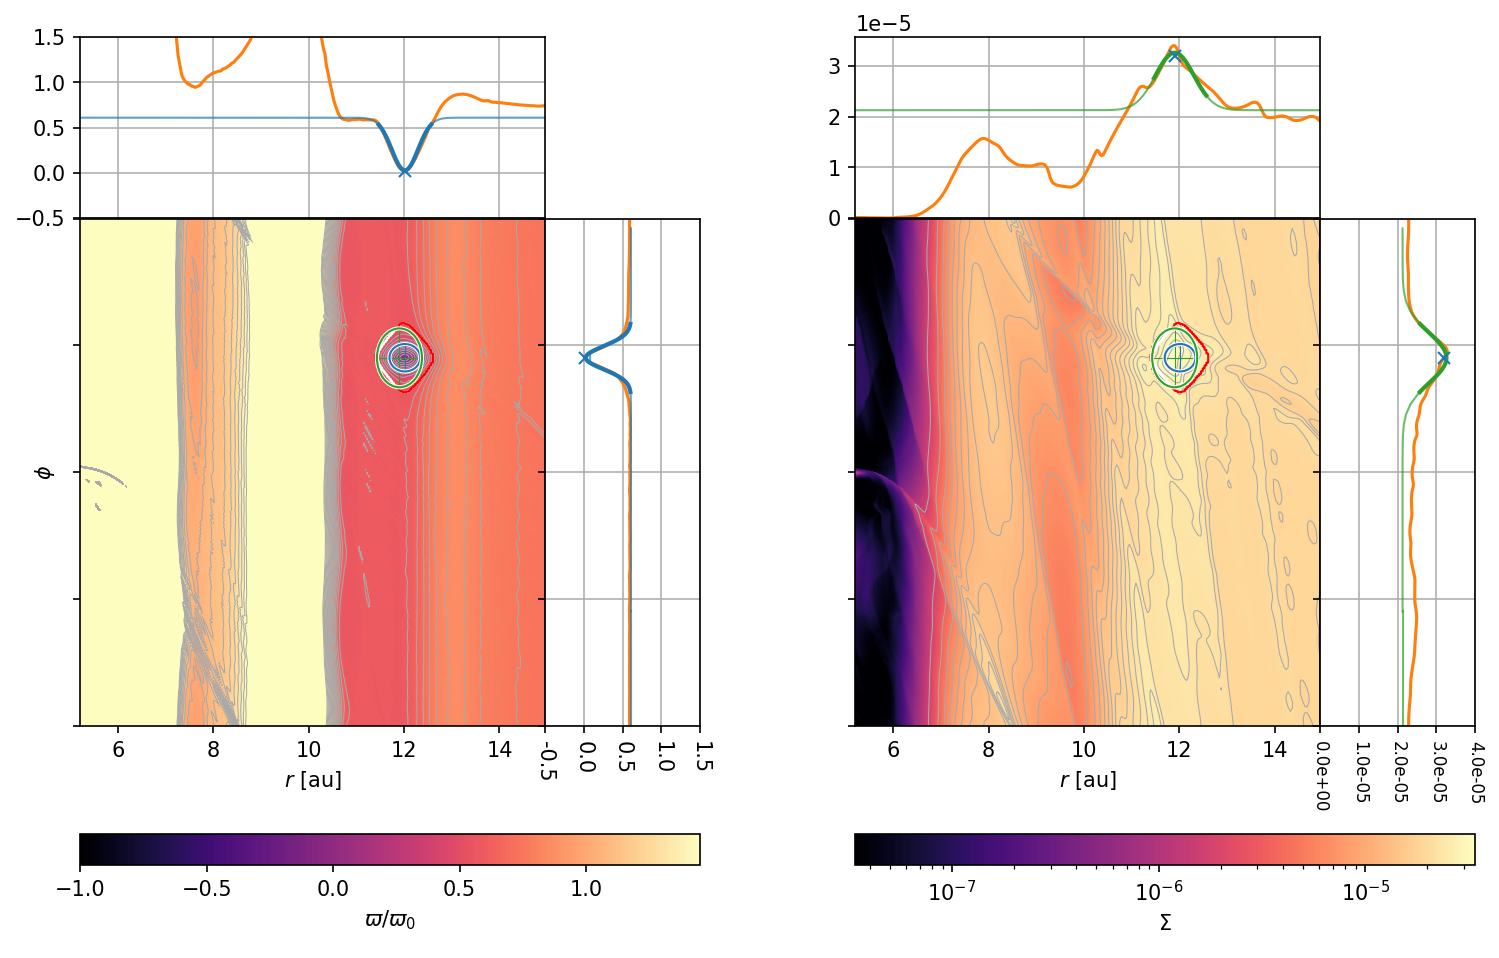

In [7]:
Rlims = [5.2, 15]
nl = np.argmin(np.abs(Xc[:,0]-Rlims[0]))
nr = np.argmin(np.abs(Xc[:,0]-Rlims[1]))
vd = Vortector(Xc[nl:nr,:], Yc[nl:nr,:], A[nl:nr,:], vortensity[nl:nr,:], Rho[nl:nr,:],
                         verbose=True, med=0.15, mear=np.inf,
                         levels=levels
                        )
%time vortices = vd.detect(include_mask=True, keep_internals=False)

show_fit_overview_2D(vd)

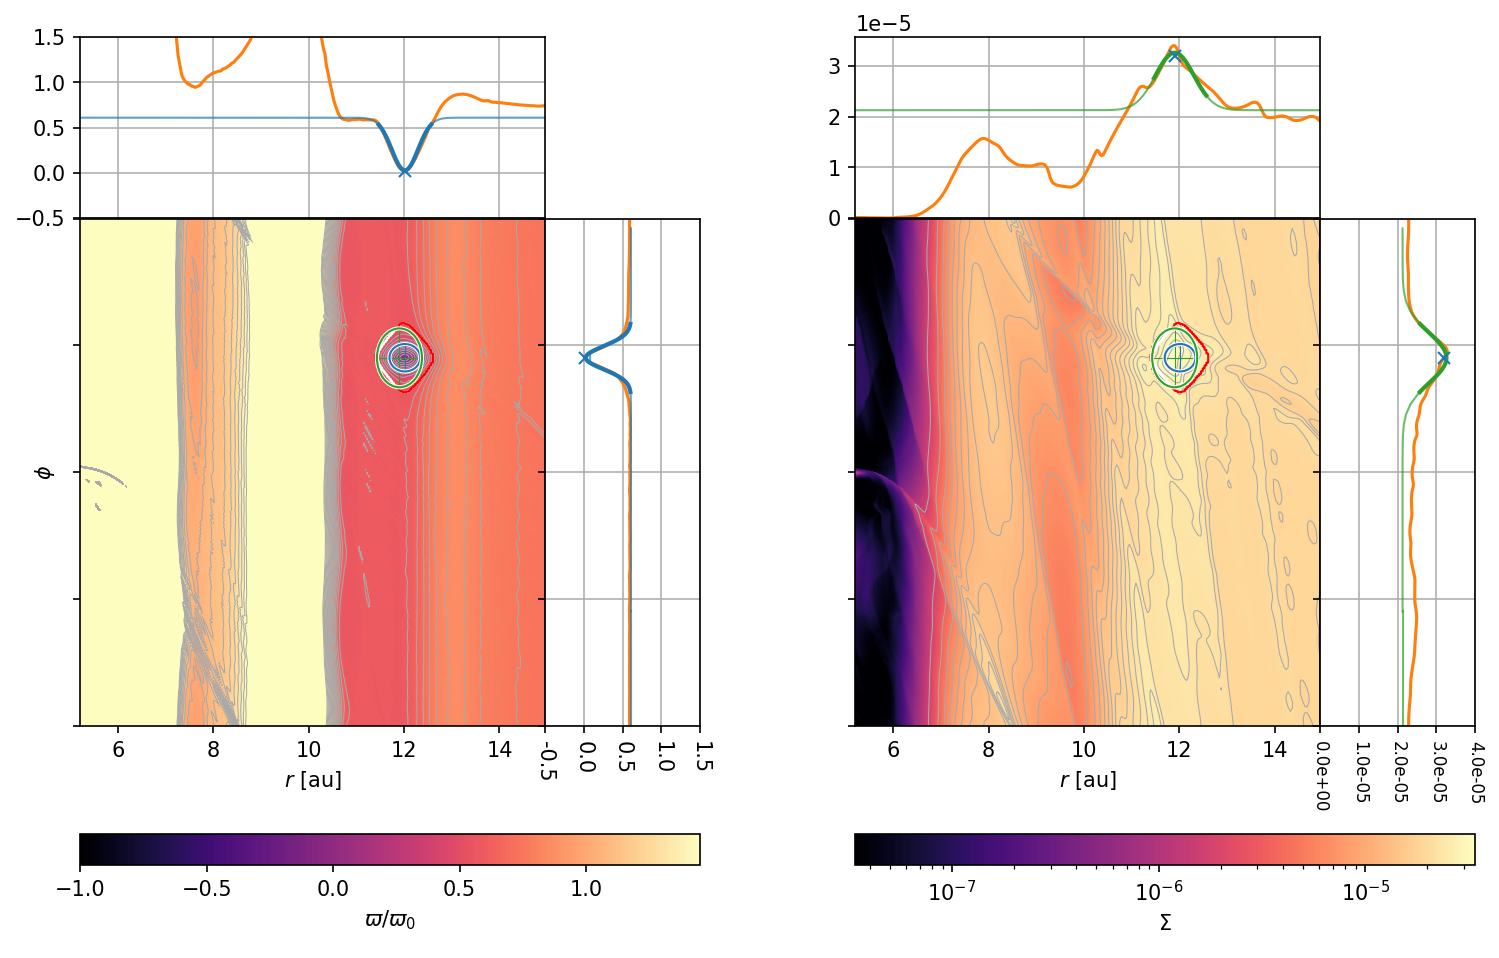

In [8]:
show_fit_overview_2D(vd)

In [9]:
vort = vd.vortices[0]

X, Y, Zv, Zd, mask = vd.extract_data(vort, region="combined")

N_levels = min(int(np.min(Zd.shape)/2), 15)
print(N_levels)
levels_d = np.linspace(np.min(Zd), np.max(Zd), N_levels)
levels_v = np.arange(-1, 1, 0.05)

15


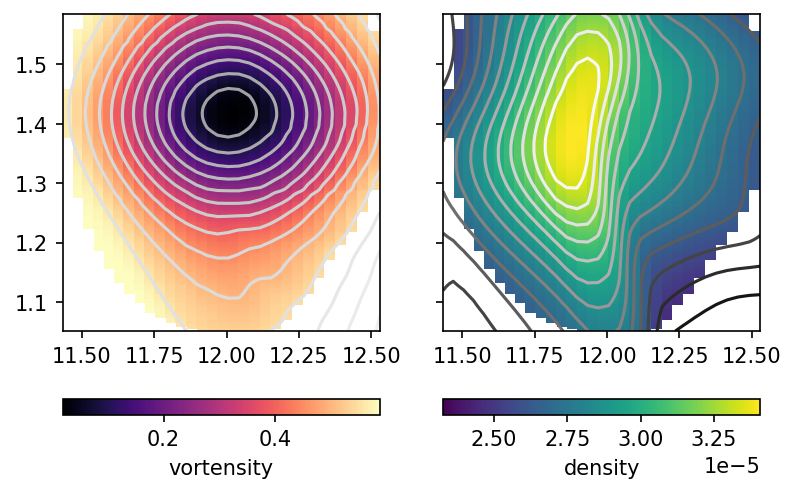

In [20]:
def colormesh_plot(ax, X , Y, Z, levels, label, cmap="viridis", vlim=None):
    if vlim is None:
        vlim = (levels[0], levels[-1])
    im = ax.pcolormesh(X, Y, Z, vmax=vlim[1], vmin=vlim[0], cmap=cmap)
    ax.contour(X,Y,Z,cmap="Greys_r", levels=levels)
    cbar = ax.get_figure().colorbar(im, ax=ax, orientation="horizontal")
    cbar.set_label(label)
    ax.pcolormesh(X, Y, np.ma.masked_array(np.ones(Z.shape), mask=mask), cmap="binary")

fig, axes = plt.subplots(1,2,dpi=150, sharex="all", sharey="all")
colormesh_plot(axes[0], X, Y, Zv, levels_v, "vortensity", cmap="magma", vlim=[np.min(Zv[mask]), np.max(Zv[mask])])
colormesh_plot(axes[1], X, Y, Zd, levels_d, "density")

# im_d = axes[1].pcolormesh(X, Y, Zd, vmax=levels_d[-1], vmin=levels_d[0])
# axes[1].contour(X,Y,Zd,cmap="Greys_r", levels=levels_d)
# cbar_d = fig.colorbar(im_d, ax=axes[1], orientation="horizontal")
# cbar_d.set_label("density")

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Rs = X[:,0]
Phis = Y[0]

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.15)

fig.add_trace(
    go.Heatmap(
        x = Rs,
        y = Phis,
        z = Zv,
        colorscale = "magma",
        colorbar = dict(title="vortensity", x=0.45
                       )
    ),
    row=1, col=1
)

fig.add_trace(go.Heatmap(
        x = Rs,
        y = Phis,
        z = Zd,
        colorscale = "Viridis",
        colorbar = dict(title="surface density")
    ),
    row=1, col=2
)


fig.update_layout(
    xaxis = dict(title="r [au]"),
    yaxis = dict(title="phi [rad]"),
    xaxis2 = dict(title="r [au]"),
    yaxis2 = dict(showticklabels = False),
)

fig.show()

In [13]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Rs = X[:,0]
Phis = Y[0]

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Heatmapgl(
        x = Rs,
        y = Phis,
        z = Zv,
        colorscale = "magma",
        colorbar = dict(title="vortensity")
    ),
    row=1, col=1
)



fig.update_layout(
    xaxis = dict(title="r [au]"),
    yaxis = dict(title="phi [rad]")
)

fig.show()

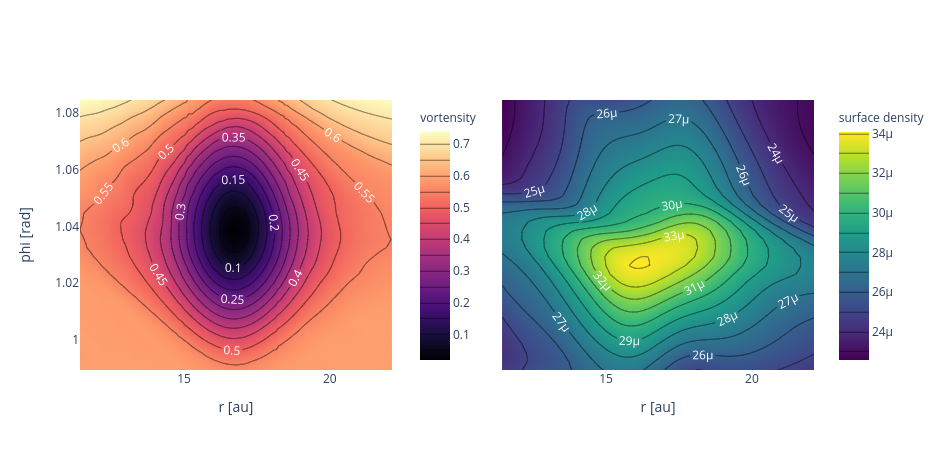

In [60]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Rs = X[:,0]
Phis = Y[0]

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.15)

fig.add_trace(
    go.Contour(
        x = Rs,
        y = Phis,
        z = Zv,
        contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            )
        ),
        colorscale = "magma",
        colorbar = dict(title="vortensity", x=0.45, nticks=10)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Contour(
        x = Rs,
        y = Phis,
        z = Zd,
        contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            )
        ),
        colorscale = "Viridis",
        colorbar = dict(title="surface density")
    ),
    row=1, col=2
)


fig.update_layout(
    xaxis = dict(title="r [au]"),
    yaxis = dict(title="phi [rad]"),
    xaxis2 = dict(title="r [au]"),
    yaxis2 = dict(showticklabels = False),
)

fig.show()

In [14]:
from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State


# data1 = [go.Contour(
#         x = vd.radius[:,0],
#         y = vd.azimuth[0],
#         z = vd.vortensity.T,
#         contours=dict(
#             coloring ='heatmap',
#             showlabels = True, # show labels on contours
#             labelfont = dict( # label font properties
#                 size = 12,
#                 color = 'white'
#             )
#         ),
#         zmax=1, zmin=-1,
#         colorscale = "magma",
#         colorbar = dict(title="vortensity", nticks=10)
#     )]



# data2 = [go.Contour(
#         x = vd.radius[:,0],
#         y = vd.azimuth[0],
#         z = vd.surface_density.T,
#         contours=dict(
#             coloring ='heatmap',
#             showlabels = True, # show labels on contours
#             labelfont = dict( # label font properties
#                 size = 12,
#                 color = 'white',
#             )
#         ),
#         colorscale = "Viridis",
#         colorbar = dict(title="surface density")
#     )]

data1 = [go.Heatmapgl(
        x = vd.radius[:,0],
        y = vd.azimuth[0],
        z = vd.vortensity.T,
        zmax=1, zmin=-1,
        colorscale = "magma",
        colorbar = dict(title="vortensity", nticks=10)
    )]



data2 = [go.Heatmapgl(
        x = vd.radius[:,0],
        y = vd.azimuth[0],
        z = vd.surface_density.T,
        colorscale = "Viridis",
        colorbar = dict(title="surface density")
    )]

fig={'data':[go.Scatter(x=np.random.randint(1,100,10), y=np.random.randint(1,100,10),mode='markers')]}

app=JupyterDash()

app.layout = html.Div([
html.Div([
dcc.Graph(id='graph',figure={"data" : data1} ),
dcc.Graph(id='graph2', figure={"data" : data2} ),
],
style={'columnCount': 2}
),
html.Div([
    html.Pre(id='relayout-data', style={'border': 'thin lightgrey solid','overflow':'scroll'})
])])

@app.callback(Output('relayout-data', 'children'),
                      [Input('graph', 'relayoutData')])
def display_relayout_data(relayoutData):
     return json.dumps(relayoutData, indent=2)



@app.callback(Output('graph2', 'figure'),
             [Input('graph', 'relayoutData')], 
             [State('graph2', 'figure')])
def graph_event(select_data,  fig):
    try:
        if "xaxis.range[0]" in select_data:
            fig['layout'] = {'xaxis':{'range':[select_data['xaxis.range[0]'],select_data['xaxis.range[1]']]},
                             'yaxis':{'range':[select_data['yaxis.range[0]'],select_data['yaxis.range[1]']]}}
        elif "xaxis.autorange" in select_data and "xaxis.autorange":
            fig['layout'] = {'xaxis':{'autorange':"true"},
                             'yaxis':{'autorange':"true"}}
    except (KeyError, TypeError):
        pass
    
    return fig

@app.callback(Output('graph', 'figure'),
             [Input('graph2', 'relayoutData')], 
             [State('graph', 'figure')])
def graph_event(select_data,  fig):
    try:
        if "xaxis.range[0]" in select_data:
            fig['layout'] = {'xaxis':{'range':[select_data['xaxis.range[0]'],select_data['xaxis.range[1]']]},
                             'yaxis':{'range':[select_data['yaxis.range[0]'],select_data['yaxis.range[1]']]}}
        elif "xaxis.autorange" in select_data:
            fig['layout'] = {'xaxis':{'autorange':"true"},
                             'yaxis':{'autorange':"true"}}
    except (KeyError, TypeError):
        pass
    return fig

# app.run_server(mode="jupyterlab")
app.run_server()

Dash app running on http://127.0.0.1:8050/


In [15]:
%time cnts = detect_elliptic_contours(Zd, levels_d, 10, 0.5, verbose=False, periodic=False)

CPU times: user 2.61 ms, sys: 150 µs, total: 2.76 ms
Wall time: 2.42 ms


In [17]:
Ns = cnts[0]["detection"]["descendents"]
dSigma = len(Ns)*(levels[1]-levels[0])
print(Ns, dSigma)

KeyError: 'descendents'

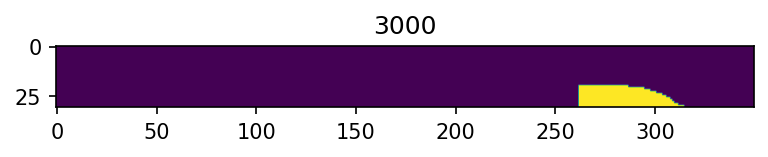

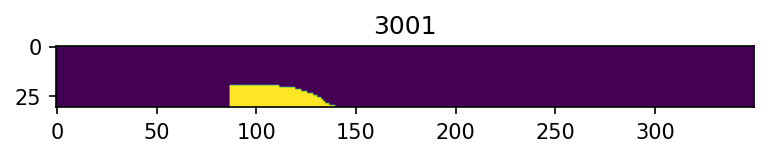

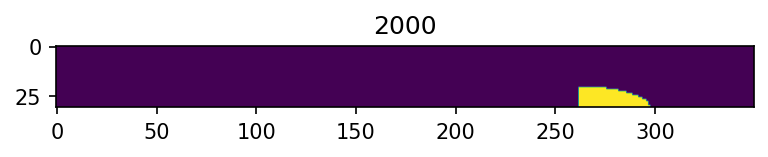

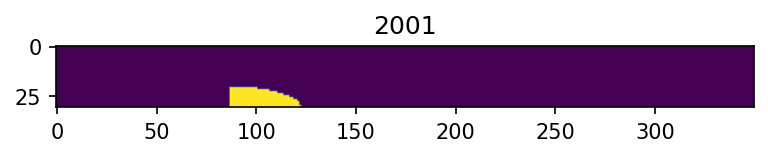

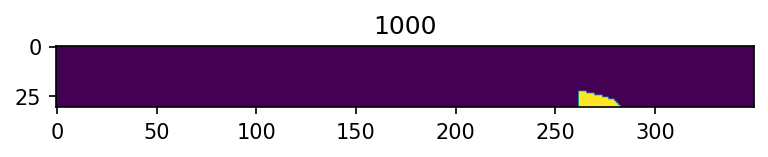

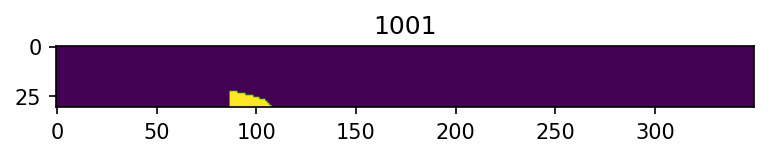

In [18]:
for cnt in cnts:
    fig, ax = plt.subplots(dpi=150)
#     ax.pcolormesh(X, Y, cnt["mask"])
    ax.imshow(cnt["mask"])
    ax.set_title(f'{cnt["detection"]["opencv_contour_number"]}')

In [ ]:
cnts[0]